In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import pandas as pd
import numpy as np
from datetime import timedelta

In [4]:
from process_raw_data import label_student_group, label_vac_type
from utils import (
    plot_age_distribution,
    plot_cumulative_booster_count, 
    plot_cumulative_incidence_rate,
    plot_num_person_days
)

### Consider all cases since 12/05/2021 and assume that they are all omicron variants.

In [5]:
OMICRON_START_DATE = '2021-12-05'
OMICRON_END_DATE = '2021-12-31'

### Eligibility

In [6]:
df = pd.read_csv("../data/data_student_vax_raw_full_population.csv")
current_pop_size = df.shape[0]
print(df.shape)
print(f"total num of students: {current_pop_size}")

# remove GR
df = df[df["academic_career"] != 'GR']
print(f"total num of students after removing {current_pop_size - df.shape[0]} GR students: {df.shape[0]}")
current_pop_size = df.shape[0]

# remove nap
df = df[df['nap'] == 0]
print(f"total num of students after removing {current_pop_size - df.shape[0]} NAPs (testing positive within 90 days before 12/5): {df.shape[0]}")
current_pop_size = df.shape[0]

# remove students not surveilled 
surveilled = pd.read_csv("../data/surveilled_population_nov_2021.csv")
df = df[df['netid_hash'].isin(list(surveilled.netid_hash))]
print(f"total num of students after removing {current_pop_size - df.shape[0]} students not surveilled in Nov 2021: {df.shape[0]}")
current_pop_size = df.shape[0]

(23389, 16)
total num of students: 23389
total num of students after removing 6372 GR students: 17017
total num of students after removing 214 NAPs (testing positive within 90 days before 12/5): 16803
total num of students after removing 130 students not surveilled in Nov 2021: 16673


In [7]:
data_student_vax = pd.read_csv("../data/data_student_vax_raw.csv")
print(data_student_vax.shape)
print(set(df.employee_id_hash) - set(data_student_vax.employee_id_hash)) # verify that df is a subset of data_student_vax
data_student_vax = data_student_vax[data_student_vax['netid_hash'].isin(list(df.netid_hash))]
print(data_student_vax.shape)

(16770, 16)
set()
(16673, 16)


In [8]:
# remove unvaccinated students
data_student_vax = data_student_vax[(data_student_vax['vac_type'] != "Not vaccinated") & (pd.to_datetime(data_student_vax['valid_from']) <= OMICRON_START_DATE)]
print(f"total num of students after removing {current_pop_size - data_student_vax.shape[0]} unvaccinated students: {data_student_vax.shape[0]}")
current_pop_size = data_student_vax.shape[0]

# remove students with unspecified sex
data_student_vax = data_student_vax[data_student_vax['current_gender'].isin(['F', 'M'])]
print(f"total num of students after removing {current_pop_size - data_student_vax.shape[0]} students with unspecified sex: {data_student_vax.shape[0]}")
current_pop_size = data_student_vax.shape[0]

# remove erroneous booster records and corresponding individuals
data_student_vax['date_received'] = pd.to_datetime(data_student_vax['date_received'])
mask = ((data_student_vax['date_received'] > '2021-08-01') & (data_student_vax['date_received'] <= '2022-02-07')) | data_student_vax['date_received'].isnull()
data_student_vax = data_student_vax.loc[mask]
print(f"total num of students after removing {current_pop_size - data_student_vax.shape[0]} students with erroneous booster records: {data_student_vax.shape[0]}")
current_pop_size = data_student_vax.shape[0]

# remove erroneous vaccination records and corresponding individuals
data_student_vax['first_dose_calendar_date'] = pd.to_datetime(data_student_vax['first_dose_calendar_date'])
mask = ((data_student_vax['first_dose_calendar_date'] >='2021-01-01') & (data_student_vax['first_dose_calendar_date'] <= '2022-02-07')) | data_student_vax['first_dose_calendar_date'].isnull()
data_student_vax = data_student_vax.loc[mask]
print(f"total num of students after removing {current_pop_size - data_student_vax.shape[0]} students with erroneous vaccination records: {data_student_vax.shape[0]}")

total num of students after removing 701 unvaccinated students: 15972
total num of students after removing 9 students with unspecified sex: 15963
total num of students after removing 50 students with erroneous booster records: 15913
total num of students after removing 113 students with erroneous vaccination records: 15800


### Data Processing

In [9]:
data_student_vax['date_received'] = pd.to_datetime(data_student_vax['date_received'])
data_student_vax['first_dose_calendar_date'] = pd.to_datetime(data_student_vax['first_dose_calendar_date'])
data_student_vax['last_test_date'] = pd.to_datetime(data_student_vax['last_test_date'])

# last dose date 
data_student_vax['last_dose_date'] = pd.to_datetime(data_student_vax['valid_from']) - timedelta(days=14)
data_student_vax['last_dose_month'] = data_student_vax['last_dose_date'].dt.month
print("earliest and latest last dose dates:", data_student_vax['last_dose_date'].min(), data_student_vax['last_dose_date'].max())
print(data_student_vax.groupby(['last_dose_month'])['employee_id_hash'].count())

# aggregate student group 
data_student_vax['student_group'] = data_student_vax.apply(lambda row: label_student_group(row), axis=1)

# aggregate vaccine type
data_student_vax['vac_type_agg'] = data_student_vax.apply(lambda row: label_vac_type(row, 'vac_type'), axis=1)
data_student_vax['booster_type_agg'] = data_student_vax.apply(lambda row: label_vac_type(row, 'booster_type'), axis=1)


earliest and latest last dose dates: 2021-01-20 00:00:00 2021-11-12 00:00:00
last_dose_month
1       43
2      313
3     1434
4     5225
5     5922
6     1214
7      814
8      541
9      249
10      42
11       3
Name: employee_id_hash, dtype: int64


### Positive cases

In [10]:
data_student_cases = pd.read_csv(f"../data/data_student_cases_raw_all_vac.csv")
print(data_student_cases.shape)
print(data_student_cases.columns)

(1939, 18)
Index(['positive_test_date', 'employee_id_hash', 'netid_hash', 'case_number',
       'academic_career', 'dob_year', 'current_gender', 'greek', 'athlete',
       'vac_type', 'first_dose_date', 'first_dose_calendar_date', 'valid_from',
       'booster', 'date_received', 'last_test_date', 'booster_type', 'nap'],
      dtype='object')


In [11]:
left_df = data_student_cases[['positive_test_date', 'case_number', 'employee_id_hash']]
data_student_cases= pd.merge(left_df, data_student_vax, how="inner", left_on='employee_id_hash', right_on='employee_id_hash')
data_student_cases.shape

(1926, 23)

In [12]:
# number of cases
num_cases = data_student_cases.shape[0]
num_booster_cases = data_student_cases[data_student_cases['date_received'] < OMICRON_START_DATE].shape[0]
print(f"total number of student cases since {OMICRON_START_DATE}: {num_cases}")
print(f"total number of student cases that received booster shots before {OMICRON_START_DATE}: {num_booster_cases}")
print(data_student_cases.groupby(['last_dose_month'])['employee_id_hash'].count())
print(data_student_cases.groupby(['vac_type_agg'])['employee_id_hash'].count())

total number of student cases since 2021-12-05: 1926
total number of student cases that received booster shots before 2021-12-05: 117
last_dose_month
1       6
2      35
3     218
4     727
5     667
6     115
7      77
8      55
9      21
10      5
Name: employee_id_hash, dtype: int64
vac_type_agg
J&J         112
Moderna     505
Others       47
Pfizer     1262
Name: employee_id_hash, dtype: int64


### Add person-day records

In [13]:
data_student_cases['num_person_days'] = pd.to_datetime(data_student_cases['positive_test_date']) \
            - pd.to_datetime(OMICRON_START_DATE) \
            + timedelta(days=1)
data_student_cases['num_person_days'] = data_student_cases['num_person_days'].dt.days

In [14]:
data_student_vax = pd.merge(data_student_vax, data_student_cases[['netid_hash', 'positive_test_date']],\
                            how='left', on="netid_hash")

num_person_days_positive_case = pd.to_datetime(data_student_vax['positive_test_date']) \
            - pd.to_datetime(OMICRON_START_DATE) \
            + timedelta(days=1)

num_person_days_negative_case = pd.to_datetime(data_student_vax['last_test_date']) \
            - pd.to_datetime(OMICRON_START_DATE) \
            + timedelta(days=1)

# filter out students with num_person_days = 0
data_student_vax.loc[data_student_vax.positive_test_date.notnull(), 'num_person_days'] = num_person_days_positive_case
data_student_vax.loc[data_student_vax.positive_test_date.isnull(), 'num_person_days'] = num_person_days_negative_case
data_student_vax["num_person_days"] = data_student_vax["num_person_days"].fillna(timedelta(days=0))
data_student_vax['num_person_days'] = data_student_vax['num_person_days'].dt.days

In [15]:
total_num_students = data_student_vax.shape[0]
total_num_students_received_boosters = data_student_vax[data_student_vax['date_received'] < OMICRON_START_DATE].shape[0]
print(f"total number of eligible students: {total_num_students}")
print(f"total number of eligible students that received booster shots before {OMICRON_START_DATE}: {total_num_students_received_boosters}")

total number of eligible students: 15800
total number of eligible students that received booster shots before 2021-12-05: 1876


### Overall attack rate calculation

In [16]:
print(f"overall omicron variant attack rate: {num_cases / total_num_students:.3f}")
print(f"omicron variant attack rate among student that received booster shots: {num_booster_cases / total_num_students_received_boosters:.3f}")
print(f"omicron variant attack rate among student that have not received booster shots: {(num_cases - num_booster_cases) / (total_num_students - total_num_students_received_boosters):.3f}")

overall omicron variant attack rate: 0.122
omicron variant attack rate among student that received booster shots: 0.062
omicron variant attack rate among student that have not received booster shots: 0.130


### Saving data

In [17]:
data_student_cases.to_csv(f"../data/data_student_cases.csv", index=False)
data_student_vax.to_csv(f"../data/data_student_vax.csv", index=False)

### Students with nonzero person-days

num students with non zero person-days: 15515; fraction: 0.982
Person day statistics over all students
 count    15800.000000
mean         9.813671
std          4.528349
min          0.000000
25%          8.000000
50%         10.000000
75%         12.000000
max         27.000000
Name: num_person_days, dtype: float64
Plot of person_day_distribution saved to ../figures/


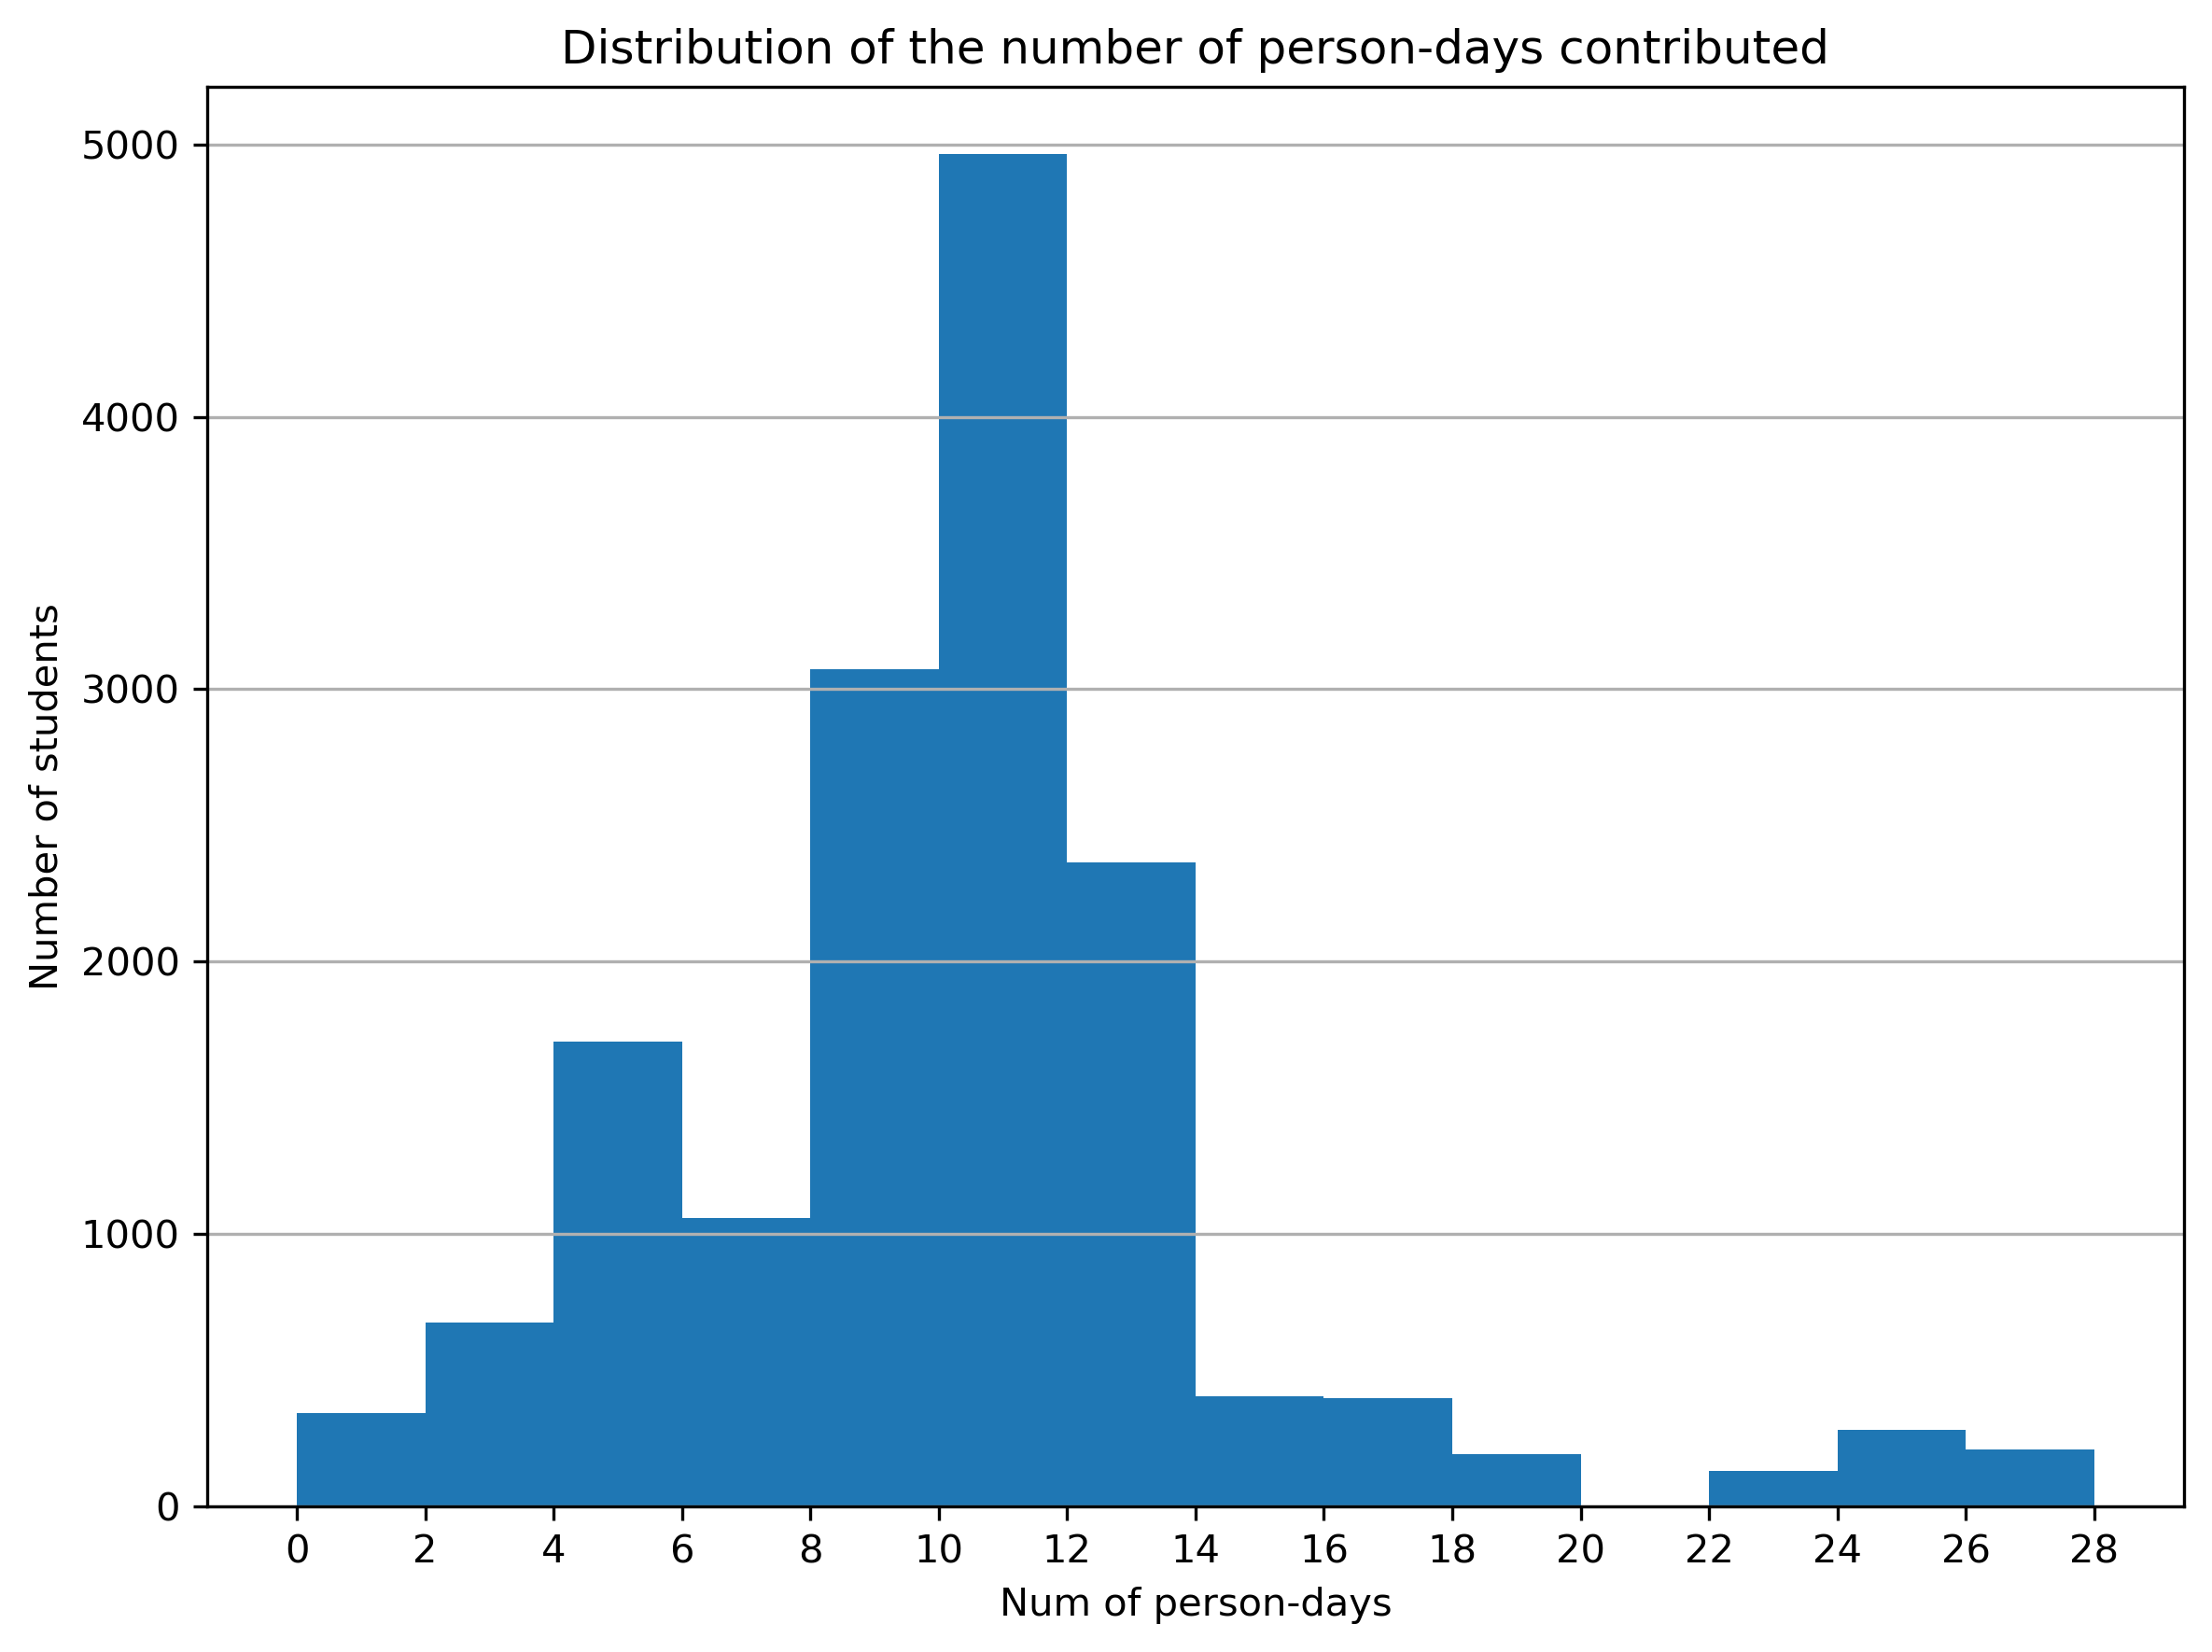

In [18]:
num_students_nonzero_person_day = data_student_vax[data_student_vax.num_person_days >= 1].shape[0]
total_num_students = data_student_vax.shape[0]

print(f"num students with non zero person-days: {num_students_nonzero_person_day}; fraction: {num_students_nonzero_person_day / total_num_students:.3f}")
print(f"Person day statistics over all students\n", data_student_vax["num_person_days"].describe())

plot_num_person_days(data_student_vax)

### Person days that fall into Dec 5 - Dec 14

In [19]:
num_person_days = list(data_student_vax.num_person_days)
sum(num_person_days)

155056

In [20]:
num_person_days_in_surveillance = [d if d <= 10 else 10 for d in num_person_days]
sum(num_person_days_in_surveillance)

132693

In [21]:
print(sum(num_person_days_in_surveillance) / sum(num_person_days))

0.8557746878547106


### Earliest booster date

In [22]:
print(data_student_vax.date_received.min())

2021-08-03 00:00:00


### Booster type distribution

In [23]:
df_booster_type = pd.pivot_table(data_student_vax[data_student_vax['date_received'] <= OMICRON_START_DATE], values='netid_hash', index=['booster_type_agg'], columns=['vac_type_agg'], aggfunc=lambda x: len(x.unique()))
df_booster_type.fillna(0, inplace=True)
df_booster_type

vac_type_agg,J&J,Moderna,Others,Pfizer
booster_type_agg,,,,
J&J,3.0,1.0,0.0,3.0
Moderna,39.0,243.0,58.0,131.0
Others,0.0,0.0,2.0,0.0
Pfizer,81.0,67.0,140.0,1136.0


In [24]:
df_booster_type_ext = pd.pivot_table(data_student_vax[data_student_vax['date_received'] <= OMICRON_END_DATE], values='netid_hash', index=['booster_type_agg'], columns=['vac_type_agg'], aggfunc=lambda x: len(x.unique()))
df_booster_type_ext.fillna(0, inplace=True)
df_booster_type_ext

vac_type_agg,J&J,Moderna,Others,Pfizer
booster_type_agg,,,,
J&J,27.0,5.0,0.0,8.0
Moderna,129.0,1644.0,84.0,878.0
Others,0.0,0.0,2.0,1.0
Pfizer,168.0,454.0,207.0,4262.0


In [25]:
data_student_vax.groupby("vac_type_agg")['employee_id_hash'].count()

vac_type_agg
J&J          815
Moderna     4214
Others       704
Pfizer     10067
Name: employee_id_hash, dtype: int64

In [26]:
df = pd.read_csv(f"../data/data_student_vax.csv")
df = df[df['date_received'].notnull()]
df['date_received'] = pd.to_datetime(df['date_received'])
df = df.groupby(['date_received'])['netid_hash'].count().cumsum().reset_index()
df = df.rename(columns={'netid_hash': 'cum_num_students_boosted'})
df = df[df['date_received'] <= '2021-12-31']
num_boosted_before = int(df[df['date_received'] == '2021-12-04']['cum_num_students_boosted'])
num_boosted_during = int(df[df['date_received'] == '2021-12-31']['cum_num_students_boosted']) - num_boosted_before
num_boosted_after = total_num_students - num_boosted_before - num_boosted_during
print(f"# students boosted before study period: {num_boosted_before}")
print(f"# students boosted during study period: {num_boosted_during}")
print(f"# students unboosted or boosted after study period: {num_boosted_after}")

# students boosted before study period: 1876
# students boosted during study period: 5993
# students unboosted or boosted after study period: 7931


In [27]:
df_other = pd.read_csv(f"../data/data_student_vax.csv")
df_other = df_other[df_other['date_received'].notnull()]
df_other = df_other[pd.to_datetime(df_other['date_received']) <= pd.to_datetime(df_other['last_test_date'])]
df_other['date_received'] = pd.to_datetime(df_other['date_received'])
df_other = df_other.groupby(['date_received'])['netid_hash'].count().cumsum().reset_index()
df_other = df_other.rename(columns={'netid_hash': 'cum_num_students_boosted'})
df_other = df_other[df_other['date_received'] <= '2021-12-30'] ## cumsum of 12/30 is equal to cumsum of 12/31
num_other = int(df_other[df_other['date_received'] == '2021-12-30']['cum_num_students_boosted']) - int(df_other[df_other['date_received'] == '2021-12-04']['cum_num_students_boosted'])
print("# students boosted after leaving surveillance: ", num_boosted_during - num_other)

# students boosted after leaving surveillance:  5210


In [28]:
df = pd.read_csv(f"../data/data_student_vax.csv")
df.groupby('booster_type')['employee_id_hash'].count()

booster_type
J&J             116
Moderna        4509
Not boosted    2735
Others            7
Pfizer         8433
Name: employee_id_hash, dtype: int64

### Cumulative booster count (study population)

G:\Data_Peter\booster_effectiveness\src\utils.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_received'] = pd.to_datetime(df['date_received'])
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Plot of cumulative booster count saved to ../figures/


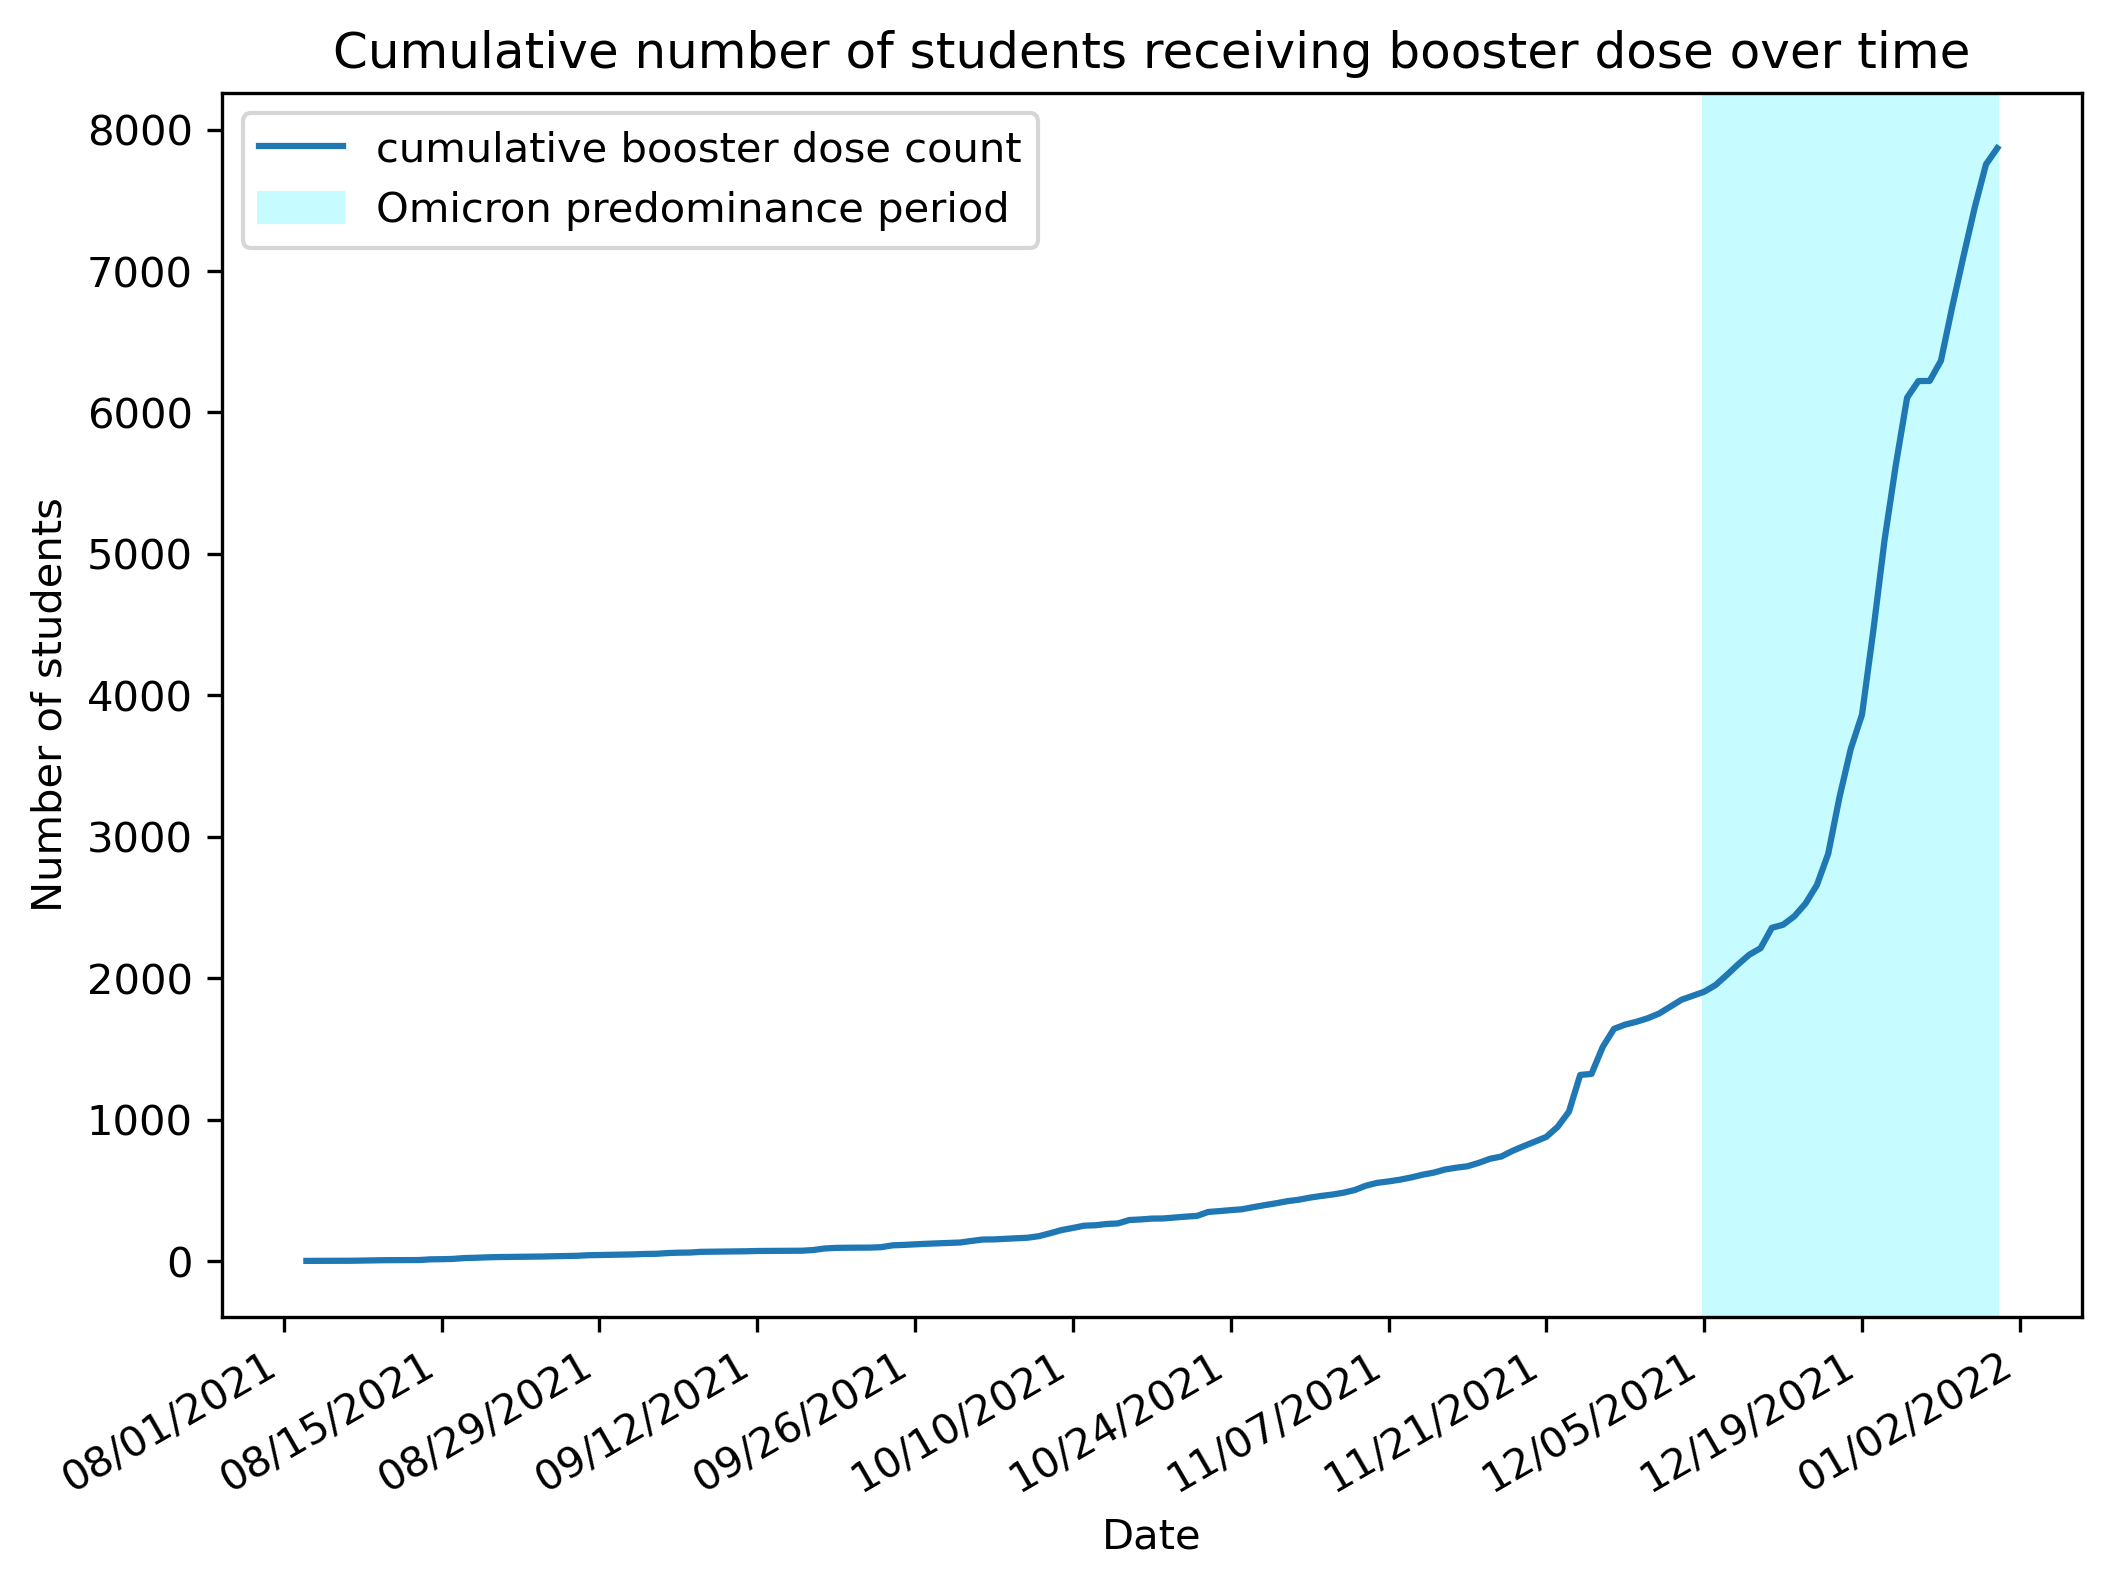

In [29]:
plot_cumulative_booster_count(data_student_vax)

### Age distribution (study population)

mean:  20.589367088607595 median:  20.0 std: 2.7926623184548034
count    15800.000000
mean        20.589367
std          2.792662
min         16.000000
25%         19.000000
50%         20.000000
75%         21.000000
max         63.000000
Name: dob_year, dtype: float64
IQR = 2.0 years
Plot of cumulative booster count saved to ../figures/


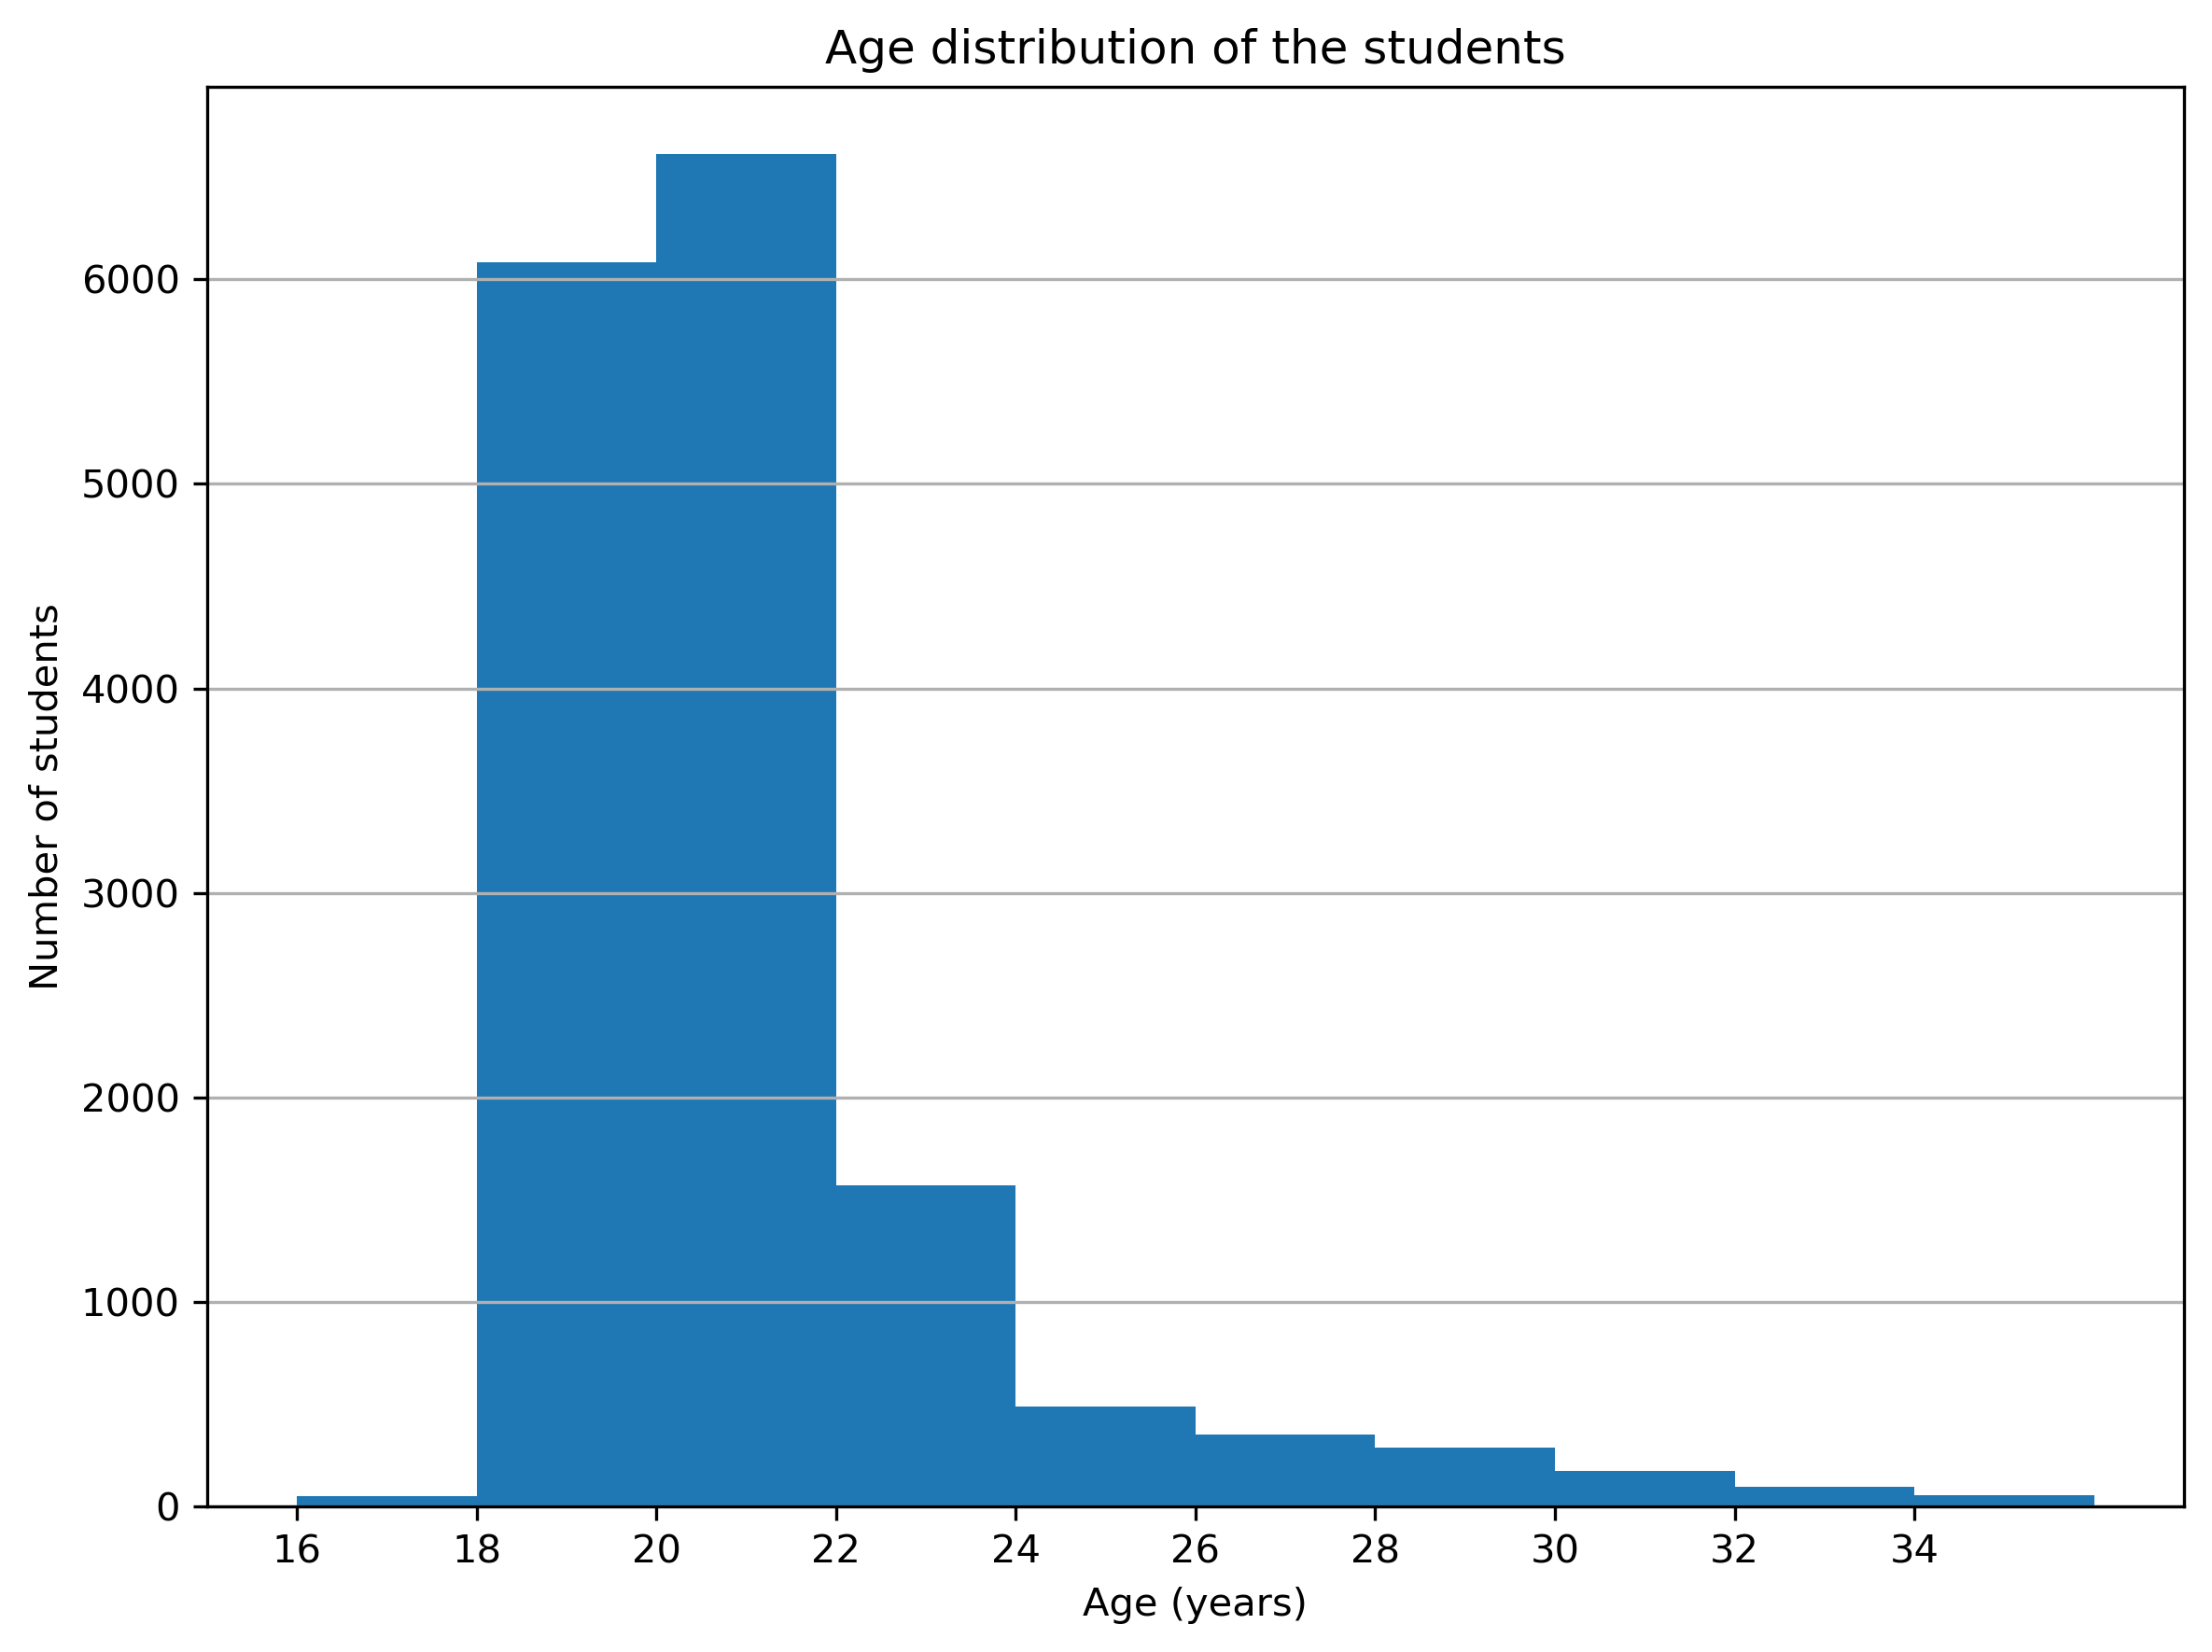

In [30]:
ages = 2021 - data_student_vax.dob_year
print("mean: ", ages.mean(), 'median: ', ages.median(), "std:", ages.std())
print(ages.describe())
print(f"IQR = {ages.describe()['75%'] - ages.describe()['25%']} years")
plot_age_distribution(data_student_vax)

### Cunmulative incidence rate (study population)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Plot of cumulative incidence rate saved to ../figures/


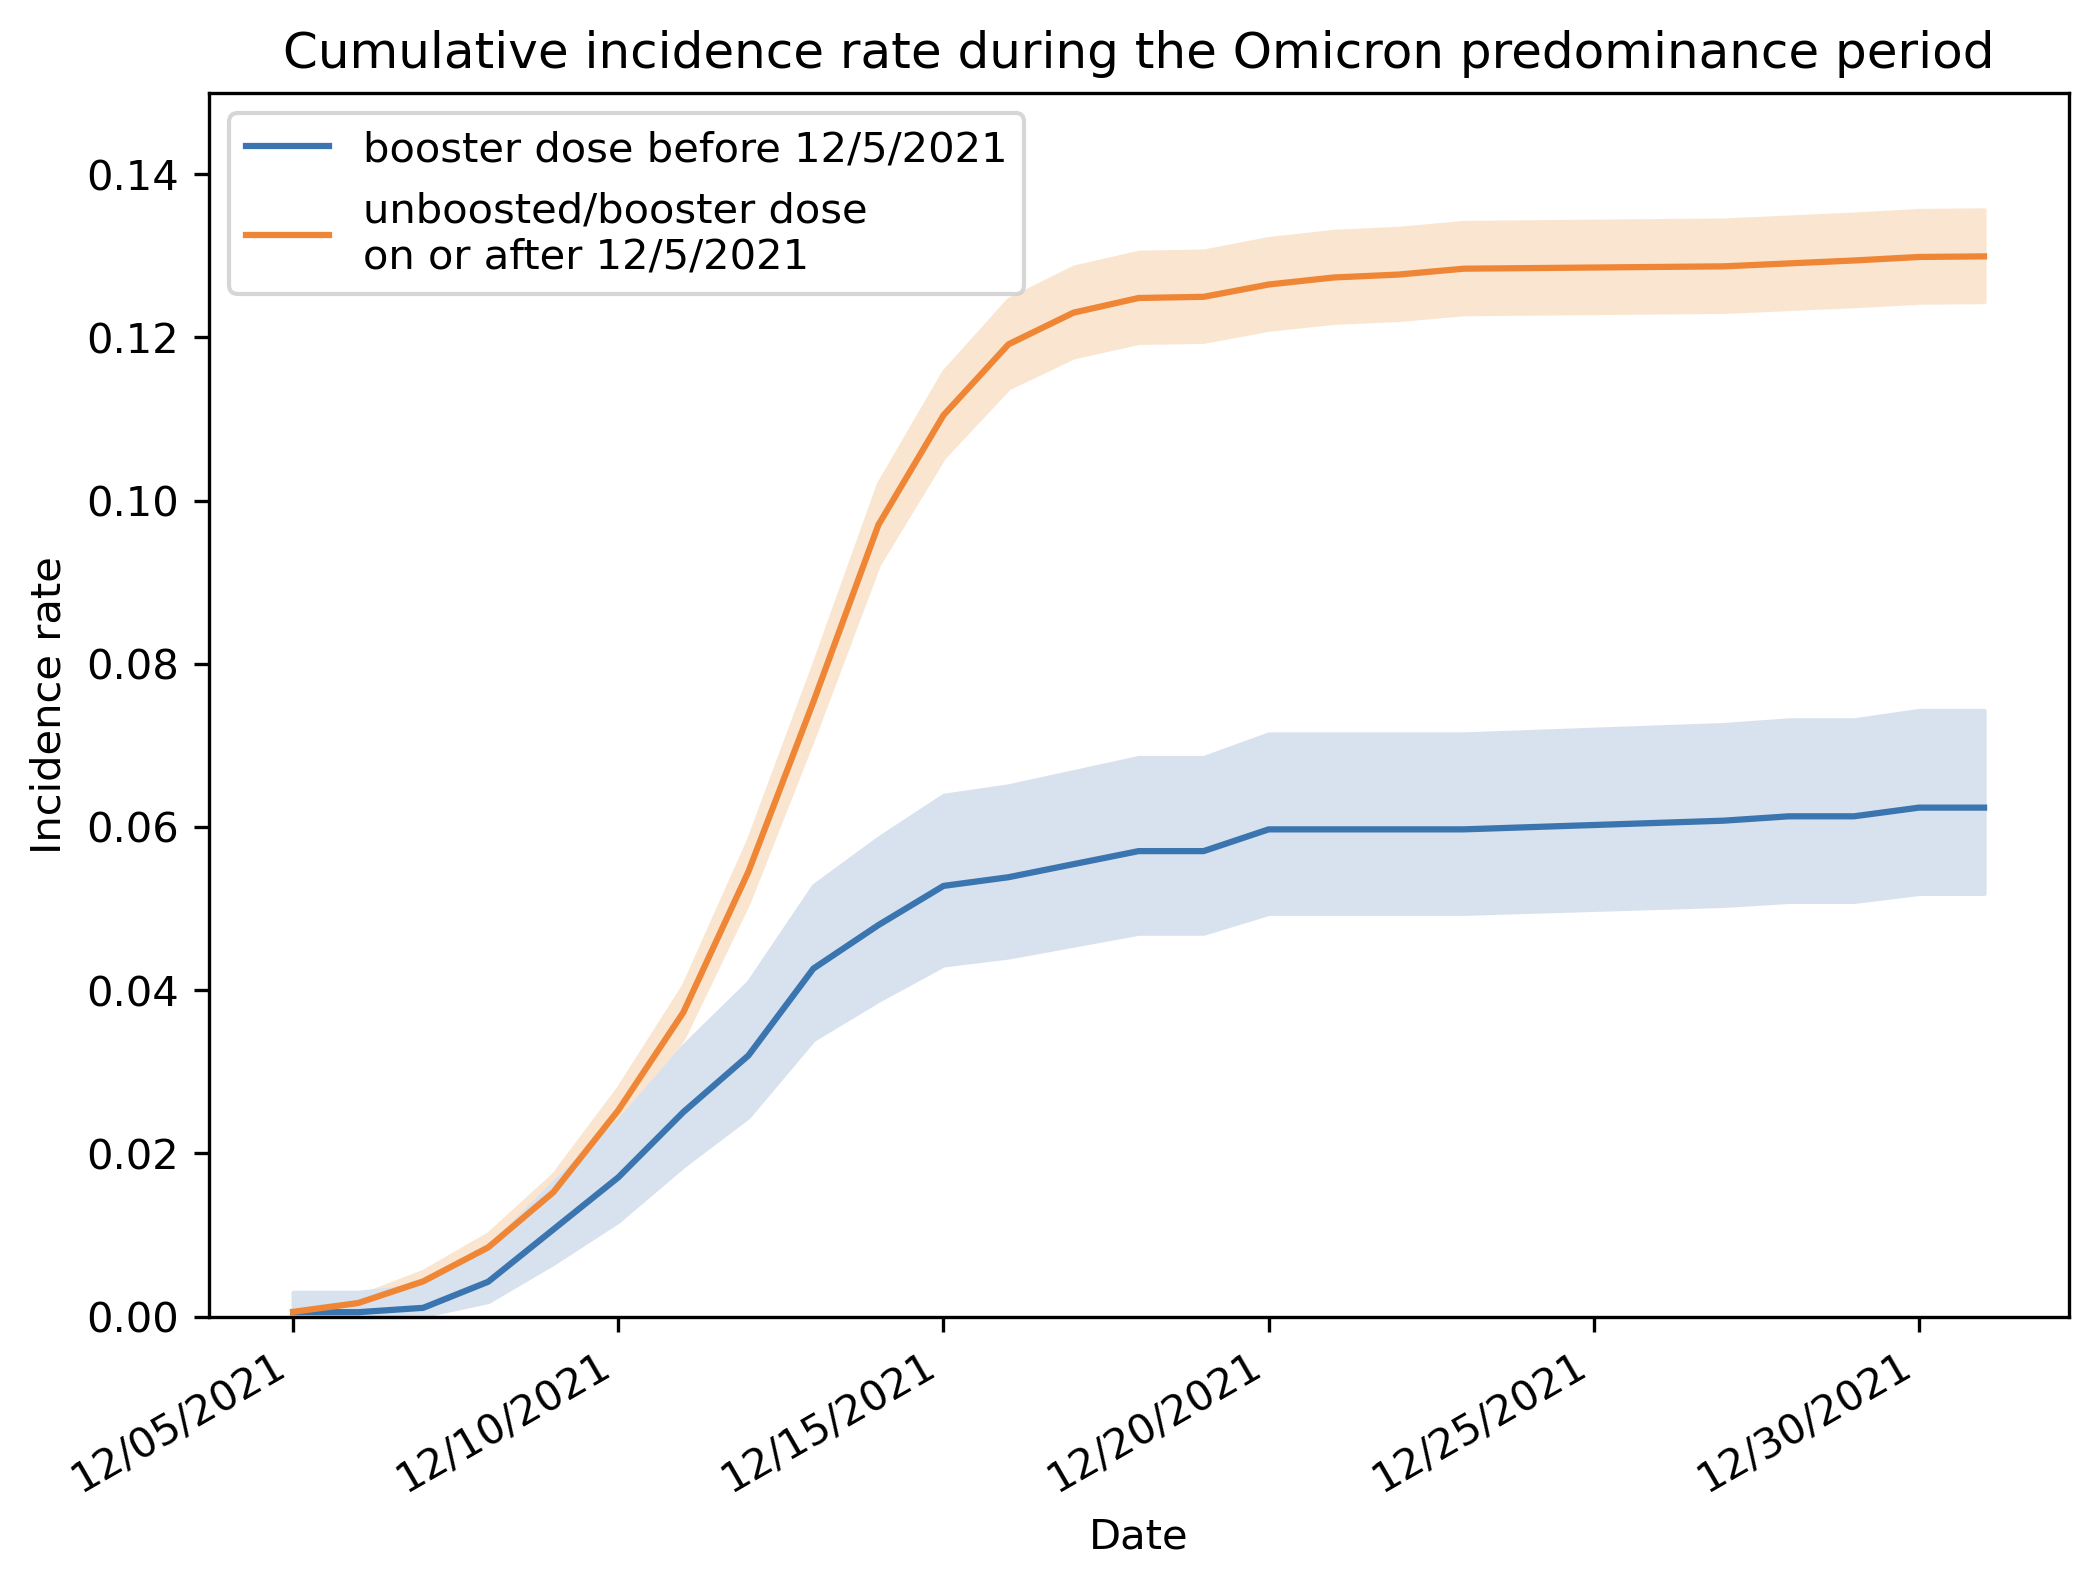

In [31]:
plot_cumulative_incidence_rate(df=data_student_vax, df_pos=data_student_cases)

### Test distribution

In [32]:
df_test = pd.read_csv("../data/test_count_study_period.csv")
df_test.shape

(15806, 2)

In [33]:
df_test = df_test[df_test.employee_id_hash.isin(list(data_student_vax.employee_id_hash))]

In [34]:
df_test.groupby('num_tests')['employee_id_hash'].count()

num_tests
0      285
1     2712
2     6955
3     3553
4     1409
5      494
6      223
7       97
8       43
9       20
10       5
11       3
12       1
Name: employee_id_hash, dtype: int64

In [35]:
df_test[df_test.num_tests >= 1].shape[0] # consistent with number of people with nonzero person-days

15515

In [36]:
df_test['num_tests'].describe()

count    15800.000000
mean         2.406519
std          1.234049
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         12.000000
Name: num_tests, dtype: float64

In [37]:
df_test['num_tests'].sum()

38023

### Winter checklist

In [38]:
checklist = pd.read_csv("../data/winter_checklist.csv")

In [39]:
checklist.columns = ['employee_id_hash', 'plans_activity', 'plans_activity_departure_date']
checklist.head(5)

,employee_id_hash,plans_activity,plans_activity_departure_date
0,0xFE9BD43CEE84CD49D50F2519E7722B1E,leaving,2021-12-16
1,0xBA72DD202C4A90BCAC82E92B313E5A2E,leaving,2022-01-13
2,0x8C037A80B3429CF4B6DF081574B7C1D8,leaving,2021-12-15
3,0xF367E98C740D90E44927B7F38F4B55F7,leaving,2021-12-17
4,0x9446993E80229127B70AFB1002E295B3,remaining,NaN


In [40]:
df_with_departure = df.merge(checklist, how='left', on='employee_id_hash')
df_with_departure.plans_activity.fillna('unknown', inplace=True)

In [41]:
df_with_departure.plans_activity_departure_date = pd.to_datetime(df_with_departure.plans_activity_departure_date)
df_with_departure[df_with_departure.plans_activity_departure_date <= '2021-12-31'].shape

(12944, 25)